递归式特征消除Recursive feature elimination(RFE)


给定一个为特征(如线性模型的系数)分配权重的外部估计量，递归特征消除([RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE))就是通过递归地考虑越来越小的特征集来选择特征。首先，对初始特征集训练估计器，通过coef_属性或feature_importances_属性获得每个特征的重要性。然后，从当前的特征集中删除最不重要的特征。在经过修剪的集合上递归地重复这个过程，直到最终达到所需的特征数量。
说简单点，递归式特征消除的主要思路是反复建立多种模型，每一次根据系数的不挑出差的特征，并去除挑出来的特征，然后在剩余的特征上重复该过程，直到遍历了所有的特征。所以递归式特征消除效果如果很看选用的模型。



In [1]:
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1  基本使用介绍

对于RFE函数，主要参数如下：
+ estimator：一种监督学习估计器，其fit方法通过coef_ 属性或feature_importances_属性提供有关要素重要性的信息
+ n_features_to_select：要保留的特征数量，默认保留一半
+ step：为整数时表示每次要删除的特征数量；小于1时表示每次去除权重最小的特征，默认为1

以下示例说明了，如何通过RFE函数挑选5个最佳特征

In [2]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

# 哪些特征入选最后特征，true表示入选
print(selector.support_)

# 每个特征的得分排名，特征得分越低（1最好），表示特征越好
print(selector.ranking_)

#  挑选了几个特征
print(selector.n_features_)



[ True  True  True  True  True False False False False False]
[1 1 1 1 1 6 4 3 2 5]
5


sklearn中[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)函数在交叉验证循环中执行RFE，以找到最佳数量的特征。RFE的稳定性很大程度上取决于迭代时用的哪种模型。RFECV 通过交叉验证的方式来执行RFE。
RFE需要一个指定数量的特性来保留，但是通常事先不知道有多少特性是有效的。为了寻找最佳特征数，采用RFE对不同特征子集进行交叉验证，并选择出最优的特征评分集合，但是如果删除特征会导致性能损失就不删除特征。这就是RFECV的原理。

对于RFECV函数，主要参数如下：
+ estimator：一种监督学习估计器，其fit方法通过coef_ 属性或feature_importances_属性提供有关要素重要性的信息
+ step：为整数时表示每次要删除的特征数量；小于1时表示每次去除权重最小的特征，默认为1
+ min_features_to_select：保留的最少的特征数（但是如果模型有特征数量限制，如随机森林设置了最大特征数，该变量需要大于等于随机森林设定的最大特征数），默认为1。
+ cv：指定交叉验证的折数，默认为5

以下示例说明了，如何通过RFECV挑选特征。如果减少特征会造成性能损失，那么将不会去除任何特征

In [3]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

# 生成样本
# X维度(50，20)，Y维度(50,1)
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)

estimator = SVR(kernel="linear")

# 5折交叉
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)

# 哪些特征入选最后特征，true表示入选
print(selector.support_)

# 每个特征的得分排名，特征得分越低（1最好），表示特征越好
print(selector.ranking_)

#  挑选了几个特征
print(selector.n_features_)
# 每次交叉迭代各个特征得分
print(selector.grid_scores_)


[ True  True  True  True  True False False False False False]
[1 1 1 1 1 6 4 3 2 5]
5
[0.2119209  0.34014969 0.32498071 0.39840786 0.44286114 0.42111785
 0.38499244 0.393591   0.39398469 0.38667796]



详细来说K折交叉验证，就是将数据集等比例划分成K份，以其中的一份作为测试数据，其他的K-1份数据作为训练数据。交叉验证实际是把实验重复做了K次，每次实验都是从K个部分选取一份不同的数据部分作为测试数据（保证K个部分的数据都分别做过测试数据），剩下的K-1个当作训练数据，最后把得到的K个实验结果进行平分。然是RFECV不是这样的，RFEC由RFE和CV(Cross-validation)组成，
RFECV源代码如下，在每次实验针对部分特征进行RFE计算。我们在所有CV上保留每个功能得分的平均值。然后，我们使用平均得分计算要删除的要素数量，然后使用整个数据集删除该数量的要素，这就是源代码所表达的意思。
举个例子如果有a，b，c三个特征，交叉认证每次提取部分特征，比如第一次提取特征(a,b)与y建模，计算在测试集的得分。第二次提取特征(a,c)进行建模，第三次对（a,b,c）进行建模。如5折交叉验证会得到5个分数数组，会对5个分数数组进行对应元素求和，得到各个特征数量下的总分，求出最高总分，以及多少特征才能达到最高分，那么就可以求得应该删多少特征，然后针对整个数据进行RFE。

```
# 提取X,y
X, y = check_X_y(X, y, "csr", ensure_min_features=2)

# Initialization
# k折交叉
cv = check_cv(self.cv, y, is_classifier(self.estimator))
scorer = check_scoring(self.estimator, scoring=self.scoring)
n_features = X.shape[1]

if 0.0 < self.step < 1.0:
    step = int(max(1, self.step * n_features))
else:
    step = int(self.step)
if step <= 0:
    raise ValueError("Step must be >0")

# Build an RFE object, which will evaluate and score each possible
# feature count, down to self.min_features_to_select
rfe = RFE(estimator=self.estimator,
          n_features_to_select=self.min_features_to_select,
          step=self.step, verbose=self.verbose)

# Determine the number of subsets of features by fitting across
# the train folds and choosing the "features_to_select" parameter
# that gives the least averaged error across all folds.

# Note that joblib raises a non-picklable error for bound methods
# even if n_jobs is set to 1 with the default multiprocessing
# backend.
# This branching is done so that to
# make sure that user code that sets n_jobs to 1
# and provides bound methods as scorers is not broken with the
# addition of n_jobs parameter in version 0.18.

if effective_n_jobs(self.n_jobs) == 1:
    parallel, func = list, _rfe_single_fit
else:
    parallel = Parallel(n_jobs=self.n_jobs)
    func = delayed(_rfe_single_fit)

# k折交叉认证
scores = parallel(
    func(rfe, self.estimator, X, y, train, test, scorer)
    for train, test in cv.split(X, y, groups))

# 计算各个交叉认证下各个元素的分数之和
scores = np.sum(scores, axis=0)
scores_rev = scores[::-1]
# 判断第几次交叉认证取得评分最大值
argmax_idx = len(scores) - np.argmax(scores_rev) - 1
# 根据设定参数step，到argmax_idx每次减少step个元素，这样能求出保留几个袁术
n_features_to_select = max(
    n_features - (argmax_idx * step),
    self.min_features_to_select)

# Re-execute an elimination with best_k over the whole set
rfe = RFE(estimator=self.estimator,
          n_features_to_select=n_features_to_select, step=self.step,
          verbose=self.verbose)

rfe.fit(X, y)
```

# 2 应用实例

下面的实例为一个递归特征消除RFE函数示例，显示了数字分类任务中像素的重要性。

In [4]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
# 读取数据集
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target
print("训练图像集的维度",X.shape)

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
# n_features_to_select=1表示每次都删除一个特征。比如X的图像为8*8的尺寸。共64个像素，对64个像素都进行排名
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
print("图像各个像素点的重要性排名：",rfe.ranking_)
# 大小重置
ranking = rfe.ranking_.reshape(digits.images[0].shape)


# Plot pixel ranking
# 颜色越浅表明该像素点对于手写数字图像分类越重要
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE");

训练图像集的维度 (1797, 64)
图像各个像素点的重要性排名： [64 50 31 23 10 17 34 51 57 37 30 43 14 32 44 52 54 41 19 15 28  8 39 53
 55 45  9 18 20 38  1 59 63 42 25 35 29 16  2 62 61 40  5 11 13  6  4 58
 56 47 26 36 24  3 22 48 60 49  7 27 33 21 12 46]


下面为一个递归特征消除示例，该示例通过交叉验证自动调整所选特征的数量。最好画出选用各个特征数量下，分类集的交叉认证分数。可以看到RFECV能够自动选择适合分类的有效特征数



X维度 (1000, 25)
y维度 (1000,)
RFEC挑选了几个特征 : 3


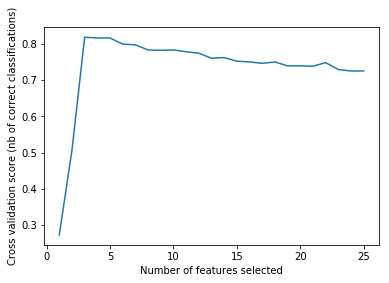

In [5]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
# 建立特征，X有25个特征，其中有效特征3个。
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)
print("X维度", X.shape)
print("y维度",y.shape)


# Create the RFE object and compute a cross-validated score.
# 创建分类器
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
# 分类
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("RFEC挑选了几个特征 : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
# 画出不同特征数量下交叉认证验证得分
plt.figure()
#  选择的特征数量
plt.xlabel("Number of features selected")
# 交叉验证得分
plt.ylabel("Cross validation score (nb of correct classifications)")
# 画出各个特征的得分
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show();

# 3 参考

> [https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

> [https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)

> [http://www.minxueyu.com/2020/03/29/RFE%E4%B8%8ERFECV%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B0/](http://www.minxueyu.com/2020/03/29/RFE%E4%B8%8ERFECV%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B0/)

> [https://blog.csdn.net/sunshunli/article/details/82355395](https://blog.csdn.net/sunshunli/article/details/82355395)

> [https://stackoverflow.com/questions/34703051/score-of-rfecv-in-python-scikit-learn](https://stackoverflow.com/questions/34703051/score-of-rfecv-in-python-scikit-learn)

> [https://blog.csdn.net/teng_zz/article/details/98027712](https://blog.csdn.net/teng_zz/article/details/98027712)